# Project Three Notebook Example

For your final notebook, feel free to duplicate this notebook and edit as needed. 


## Load Some Stuff

This is where we load libraires and the like so we can do what we need. If you get an error saying a module is not loaded, open a new terminal/cmd line and try running: `pip install [module name]`. 

In [46]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random



# Custom functions

def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):
    # Z-val equals "Yes" value. E.g., "Y" or "1". 
    # data equals df
    # col1 and col2 defines which colums to use from data
    # Plot binary decision boundary. 
    # For this, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    
    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

## Data Cleaning

Here we load the data we collected and get it all ready to feed to our statistical model(s). That is, we are trying to make a table with one **target** column and one or more **features**. Here I'm loading happiness.csv from: https://data.somervillema.gov/Happiness/Somerville-Happiness-Survey-responses-2011-2013-20/w898-3dfm Note: you can find information on the data elements at this link. 


In [47]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('childhood_mortality.csv', parse_dates=[0]) 
raw_data_df.head()

,Year,Age Group,Death Rate
0,1900-01-01,10-14 years,298.3
1,1900-01-01,1-4 years,1983.8
2,1900-01-01,15-19 years,484.8
3,1900-01-01,5-9 years,466.1
4,1901-01-01,10-14 years,273.6


In [48]:
# You can explore unique entires by stating the column and using .unique() like this:
print(raw_data_df["Year"].unique())
print(raw_data_df["Age Group"].unique())
print(raw_data_df["Death Rate"].unique())

['1900-01-01T00:00:00.000000000' '1901-01-01T00:00:00.000000000'
 '1902-01-01T00:00:00.000000000' '1903-01-01T00:00:00.000000000'
 '1904-01-01T00:00:00.000000000' '1905-01-01T00:00:00.000000000'
 '1906-01-01T00:00:00.000000000' '1907-01-01T00:00:00.000000000'
 '1908-01-01T00:00:00.000000000' '1909-01-01T00:00:00.000000000'
 '1910-01-01T00:00:00.000000000' '1911-01-01T00:00:00.000000000'
 '1912-01-01T00:00:00.000000000' '1913-01-01T00:00:00.000000000'
 '1914-01-01T00:00:00.000000000' '1915-01-01T00:00:00.000000000'
 '1916-01-01T00:00:00.000000000' '1917-01-01T00:00:00.000000000'
 '1918-01-01T00:00:00.000000000' '1919-01-01T00:00:00.000000000'
 '1920-01-01T00:00:00.000000000' '1921-01-01T00:00:00.000000000'
 '1922-01-01T00:00:00.000000000' '1923-01-01T00:00:00.000000000'
 '1924-01-01T00:00:00.000000000' '1925-01-01T00:00:00.000000000'
 '1926-01-01T00:00:00.000000000' '1927-01-01T00:00:00.000000000'
 '1928-01-01T00:00:00.000000000' '1929-01-01T00:00:00.000000000'
 '1930-01-01T00:00:00.000

In [49]:
# You can explore rows with a specific value like so
raw_data_df[raw_data_df["Age Group"]=='1-4 years'].head() # remove .head() to see all entires

,Year,Age Group,Death Rate
1,1900-01-01,1-4 years,1983.8
5,1901-01-01,1-4 years,1695.0
9,1902-01-01,1-4 years,1655.7
13,1903-01-01,1-4 years,1542.1
17,1904-01-01,1-4 years,1591.5


In [50]:
# You can count the number of rows like so
print("Size of entire table: %s "%len(raw_data_df))
print("Size of entires matching filter: %s "%len(raw_data_df[raw_data_df["Age Group"]=="5-9 years"]))

Size of entire table: 464 
Size of entires matching filter: 116 


In [67]:
raw_data_df.loc[raw_data_df['Age Group'] == '1-4 years', 'Age Group'] = 2
raw_data_df.loc[raw_data_df['Age Group'] == '5-9 years', 'Age Group'] = 7
raw_data_df.loc[raw_data_df['Age Group'] == '10-14 years', 'Age Group'] = 12
raw_data_df.loc[raw_data_df['Age Group'] == '15-19 years', 'Age Group'] = 17
raw_data_df.head()


,Year,Age Group,Death Rate,Death Likely?
0,1900-01-01,12,298.3,Y
1,1900-01-01,2,1983.8,Y
2,1900-01-01,17,484.8,Y
3,1900-01-01,7,466.1,Y
4,1901-01-01,12,273.6,Y


In [68]:
# You can add a columns like so.
raw_data_df["Death Likely?"] = "N"
raw_data_df.head()

,Year,Age Group,Death Rate,Death Likely?
0,1900-01-01,12,298.3,N
1,1900-01-01,2,1983.8,N
2,1900-01-01,17,484.8,N
3,1900-01-01,7,466.1,N
4,1901-01-01,12,273.6,N


In [69]:
# And then you can customize these new coulmns using the same method as above. 
raw_data_df.loc[raw_data_df['Death Rate'] >= 100 , 'Death Likely?'] = "Y"
raw_data_df.head()

,Year,Age Group,Death Rate,Death Likely?
0,1900-01-01,12,298.3,Y
1,1900-01-01,2,1983.8,Y
2,1900-01-01,17,484.8,Y
3,1900-01-01,7,466.1,Y
4,1901-01-01,12,273.6,Y


In [70]:
# I'm now going to make a set of tables to be used in training some models
# The first set will be for linear regressions where the traget is numeric.
# Death
death_lin_df = raw_data_df[[
                               'Death Rate', 
                               'Age Group' 
                               ]].copy()
death_lin_df.head()

,Death Rate,Age Group
0,298.3,12
1,1983.8,2
2,484.8,17
3,466.1,7
4,273.6,12


In [71]:
# The second set will be for classifiers where the target is a class.
# Death
death_class_df = raw_data_df[[
                               'Death Likely?', 
                               'Age Group'
                               ]].copy()
death_class_df.head()

,Death Likely?,Age Group
0,Y,12
1,Y,2
2,Y,17
3,Y,7
4,Y,12


## Taining and Validation

Above I created four datasets worth exploring: 
- **`happy_lin_df`**. The data needed to access *happiness* along a continuous variable.
- **`sat_lin_df`**. The data needed to access *satisfaction* along a continuous variable.
- **`happy_class_df`**. The data needed to access *happiness* as a categorical variable.
- **`sat_class_df`**. The data needed to access *satisfaction* as a categorical variable.

Let's take them each in turn. 

## death_lin_df



In [72]:
data = death_lin_df

data = data[data["Death Rate"]<2000]

holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

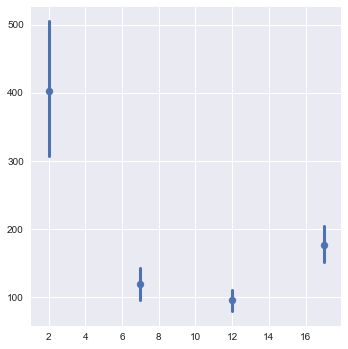

In [73]:
sns.lmplot(x="Age Group", y="Death Rate", data=training, x_estimator=np.mean, order=1)

In [76]:
model = ols("Death Rate ~ Age Group", training).fit()
#model = ols("happy ~ age + income + np.power(age, 2) + np.power(income, 2)", training).fit()
model.summary()

SyntaxError: invalid syntax (<unknown>, line 1)

In [77]:
# Rerun with SciKitLearn because it's easy to check accuracy
features_train = training.drop("Death Rate", axis=1).as_matrix(columns=None)
labels_train = training["Death Rate"].as_matrix(columns=None)

features_test = holdout.drop("Death Rate", axis=1).as_matrix(columns=None)
labels_test = holdout["Death Rate"].as_matrix(columns=None)

lm = linear_model.LinearRegression()
clf = lm.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = metrics.r2_score(labels_test, pred)
print("R squared:",lm.score(features_train,labels_train))
print("Accuracy:",accuracy)

R squared: 0.0691222078333
Accuracy: -0.136037762931


## sat_lin_df

In [ ]:
data = sat_lin_df

data = data[data["satisfied"]<=10]

holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

In [ ]:
sns.lmplot(x="age", y="satisfied", data=training, x_estimator=np.mean, order=1)

In [ ]:
sns.lmplot(x="income", y="satisfied", data=training, x_estimator=np.mean, order=1)

In [ ]:
model = ols("satisfied ~ age + income", training).fit()
model.summary()

In [ ]:
# Rerun with SciKitLearn because it's easy to check accuracy

features_train = training.drop("satisfied", axis=1).as_matrix(columns=None)
labels_train = training["satisfied"].as_matrix(columns=None)

features_test = holdout.drop("satisfied", axis=1).as_matrix(columns=None)
labels_test = holdout["satisfied"].as_matrix(columns=None)

lm = linear_model.LinearRegression()
clf = lm.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = metrics.r2_score(labels_test, pred)
print("R squared:",lm.score(features_train,labels_train))
print("Accuracy:",accuracy)

## happy_class_df

In [ ]:
data = death_class_df
holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

# Define the target (y) and feature(s) (X)
features_train = training.drop("Death Likely?", axis=1).as_matrix(columns=None)
labels_train = training["Death Likely?"].as_matrix(columns=None)

features_test = holdout.drop("Death Likely?", axis=1).as_matrix(columns=None)
labels_test = holdout["Death Likely?"].as_matrix(columns=None)

# What percentage of the time is target Y?
print("Percentage of Ys: %s\n"%(len(data[data["Death Likely?"]=="Y"])/len(data)))

#### initial visualization
feature_1_no = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_2_no = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_1_yes = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
feature_2_yes = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
plt.scatter(feature_1_yes, feature_2_yes, color = "g", label="Likely")
plt.scatter(feature_1_no, feature_2_no, color = "r", label="Unlikely")
plt.legend()
plt.xlabel("Age Group")
plt.ylabel("income")
plt.show()


In [ ]:
# Logistic Regression
model = LogisticRegression(fit_intercept = False, C = 1e9)
clf = model.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Logistic Regression")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


# Test some spot
x_test = 70
y_test = 160000
print("")
print(clf.predict([[x_test,y_test]])[0])
print(clf.predict_proba([[x_test,y_test]])[0][1])
print("")

from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=40)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("\nDecision Tree")
evaluate(pred, labels_test)
plot_bound("Y",holdout,1,2,0)



from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Random Forest")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


from sklearn.svm import SVC
clf = SVC(kernel="rbf",probability=True)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("SVM")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0) # plot doesn't work with SVM

## sat_class_df

In [ ]:
data = sat_class_df
holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

# Define the target (y) and feature(s) (X)
features_train = training.drop("satisfied_Y_N", axis=1).as_matrix(columns=None)
labels_train = training["satisfied_Y_N"].as_matrix(columns=None)

features_test = holdout.drop("satisfied_Y_N", axis=1).as_matrix(columns=None)
labels_test = holdout["satisfied_Y_N"].as_matrix(columns=None)

# What percentage of the time is target Y?
print("Percentage of Ys: %s\n"%(len(data[data["satisfied_Y_N"]=="Y"])/len(data)))

#### initial visualization
feature_1_no = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_2_no = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_1_yes = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
feature_2_yes = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
plt.scatter(feature_1_yes, feature_2_yes, color = "g", label="Happy")
plt.scatter(feature_1_no, feature_2_no, color = "r", label="Unhappy")
plt.legend()
plt.xlabel("age")
plt.ylabel("income")
plt.show()

In [ ]:
# Logistic Regression
model = LogisticRegression(fit_intercept = False, C = 1e9)
clf = model.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Logistic Regression")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


# Test some spot
x_test = 70
y_test = 160000
print("")
print(clf.predict([[x_test,y_test]])[0])
print(clf.predict_proba([[x_test,y_test]])[0][1])
print("")

from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=40)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("\nDecision Tree")
evaluate(pred, labels_test)
plot_bound("Y",holdout,1,2,0)



from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Random Forest")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


from sklearn.svm import SVC
clf = SVC(kernel="rbf",probability=True)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("SVM")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0) # plot doesn't work with SVM